<a href="https://colab.research.google.com/github/123vartika123/Web-Scraping-and-Deep-Learning/blob/main/Scraping_and_Classifying_Myntra_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web scraping with Selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
import pandas as pd
import requests
from selenium.webdriver.common.by import By

# Set up Chrome driver with service
s = Service("chromedriver.exe")
driver = webdriver.Chrome(service=s)

# List of URLs and associated metadata
urls = [
    ('https://www.myntra.com/full-sleeve-shirts-men', 'male', 'full_sleeve'),
    ('https://www.myntra.com/half-sleeve-shirts-men', 'male', 'half_sleeve'),
    ('https://www.myntra.com/full-sleeve-shirts-women', 'female', 'full_sleeve'),
    ('https://www.myntra.com/half-sleeve-shirts-women', 'female', 'half_sleeve')
]

# Initialize lists to store data
images = []
metadata = []
labels = []


# Function to scrape a single URL
def scrape_url(url, gender, sleeve_type):
    driver.get(url)
    time.sleep(5)  # Give time for the page to load
    product_elements = driver.find_elements(By.XPATH, "//li[@class='product-base']")

    for product_element in product_elements:
        try:
            # Get image URL
            image_url = product_element.find_element(By.XPATH, ".//img").get_attribute("src")

            # Download image
            response = requests.get(image_url)
            image_path = 'images/' + gender + '/' + sleeve_type + '/' + image_url.split('/')[-1]
            with open(image_path, 'wb') as f:
                f.write(response.content)

            # Get metadata
            product_brand = product_element.find_element(By.XPATH, ".//h3[@class='product-brand']").text
            product_name = product_element.find_element(By.XPATH, ".//h4[@class='product-product']").text
            product_price = product_element.find_element(By.XPATH, ".//span[@class='product-discountedPrice']").text

            # Add data to lists
            images.append(image_path)
            metadata.append(f"{product_brand} - {product_name} - {product_price}")
            labels.append((gender, sleeve_type))

        except Exception as e:
            print(f"Error scraping product: {e}")


# Scrape each URL
for url, gender, sleeve_type in urls:
    scrape_url(url, gender, sleeve_type)

# Convert lists to DataFrame
data = {'image_path': images, 'metadata': metadata, 'gender': [label[0] for label in labels],
        'sleeve_type': [label[1] for label in labels]}
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_filename = 'myntra_data.csv'
df.to_csv(csv_filename, index=False)

print("Data scraping completed. Data saved to 'myntra_data.csv'")

# Close the browser
driver.quit()


#Image classification code

In [8]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the CSV file
csv_file = 'myntra_data.csv'  # Adjust this path as needed
df = pd.read_csv(csv_file)

# Initialize lists to store data and labels
images = []
gender_labels = []
sleeve_labels = []

# Load images and labels
for index, row in df.iterrows():
    image_path = row['image_path']  # Use the image_path directly from the CSV
    print(f"Loading image: {image_path}")

    # Check if the image exists
    if not os.path.isfile(image_path):
        print(f"Image file does not exist: {image_path}")
        continue

    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    image = cv2.resize(image, (128, 128))  # Resize image to 128x128
    images.append(image)
    gender_labels.append(1 if row['gender'] == 'male' else 0)
    sleeve_labels.append(1 if row['sleeve_type'] == 'full_sleeve' else 0)

# Convert lists to numpy arrays
images = np.array(images)
gender_labels = to_categorical(gender_labels, 2)
sleeve_labels = to_categorical(sleeve_labels, 2)

print(f"Loaded {len(images)} images.")
print(f"Image array shape: {images.shape}")

# Split data into training and testing sets
X_train, X_test, y_gender_train, y_gender_test, y_sleeve_train, y_sleeve_test = train_test_split(
    images, gender_labels, sleeve_labels, test_size=0.2, random_state=42
)


Loading image: images/male/full_sleeve/585db9fe-1df0-458d-b218-6f514eabb9601553068826233-Mast--Harbour-Men-Shirts-4141553068825026-1.jpg
Loading image: images/male/full_sleeve/779ac019-8b8c-48f7-9c5e-b3e2fe3004b01645166457327-Men-White-Casual-Shirt-5731645166456476-1.jpg
Loading image: images/male/full_sleeve/9a71effc-5ca8-4f56-94c0-2c71054102101566218377789-Roadster-Men-Shirts-8021566218376333-1.jpg
Loading image: images/male/full_sleeve/605acdc7-6157-48eb-84f0-27e432126c611591355165720-Mast--Harbour-Men-Shirts-4111591355163609-1.jpg
Loading image: images/male/full_sleeve/fe1322b7-9e53-4b6e-8423-0a4f5a9e8b4b1565006161882-Roadster-Men-Shirts-8701565006159466-1.jpg
Loading image: images/male/full_sleeve/02fd5910-6f17-4bda-ba8f-ddf698c5cac81676013985849THEBEARHOUSEMenPurpleSlimFitCasualShirt4.jpg
Loading image: images/male/full_sleeve/49f8c1fa-a4aa-45a8-960f-c5ad8eae3fde1574328384416-Roadster-Men-Navy-Blue--Pink-Regular-Fit-Checked-Casual-Shir-1.jpg
Loading image: images/male/full_sleeve

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a simple CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # For gender classification

    return model

# Create and compile the model for gender classification
gender_model = create_model()
gender_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the gender classification model
history_gender = gender_model.fit(X_train, y_gender_train, epochs=10, validation_split=0.2, batch_size=32)

# Evaluate the gender classification model
gender_loss, gender_accuracy = gender_model.evaluate(X_test, y_gender_test)
print(f"Gender classification - Loss: {gender_loss}, Accuracy: {gender_accuracy}")

# Create and compile the model for sleeve type classification
sleeve_model = create_model()
sleeve_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the sleeve type classification model
history_sleeve = sleeve_model.fit(X_train, y_sleeve_train, epochs=10, validation_split=0.2, batch_size=32)

# Evaluate the sleeve type classification model
sleeve_loss, sleeve_accuracy = sleeve_model.evaluate(X_test, y_sleeve_test)
print(f"Sleeve type classification - Loss: {sleeve_loss}, Accuracy: {sleeve_accuracy}")


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 10.4365 - accuracy: 0.5200 - val_loss: 247.5692 - val_accuracy: 0.5714
Epoch 2/10
1/1 [==============================] - 1s 802ms/step - loss: 289.2011 - accuracy: 0.4800 - val_loss: 152.3133 - val_accuracy: 0.4286
Epoch 3/10
1/1 [==============================] - 1s 827ms/step - loss: 90.9525 - accuracy: 0.5600 - val_loss: 80.2187 - val_accuracy: 0.4286
Epoch 4/10
1/1 [==============================] - 1s 825ms/step - loss: 51.6139 - accuracy: 0.6400 - val_loss: 3.2761 - val_accuracy: 0.4286
Epoch 5/10
1/1 [==============================] - 1s 819ms/step - loss: 6.4680 - accuracy: 0.6800 - val_loss: 39.7773 - val_accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - 1s 794ms/step - loss: 41.4981 - accuracy: 0.4800 - val_loss: 15.7279 - val_accuracy: 0.5714
Epoch 7/10
1/1 [==============================] - 1s 781ms/step - loss: 21.0573 - accuracy: 0.5600 - val_loss: 4.7364 - val_accuracy: 0.4286
Epoch 8/1

1/1 [==============================] - 0s 45ms/step


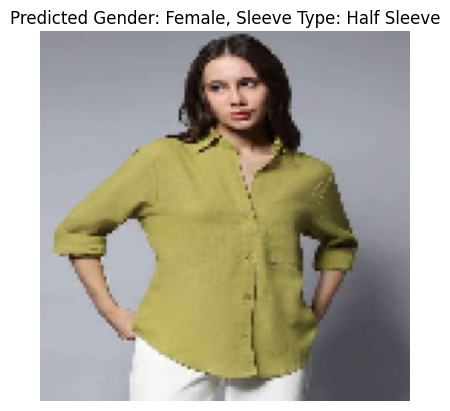

Image: /content/images/female/full_sleeve/19ee012f-d1bc-4a95-a46d-bdbcb84b01e91691438760543HighStarWomenGreenClassicOpaqueCasualShirt1.jpg
Predicted Gender: Female
Predicted Sleeve Type: Half Sleeve


1/1 [==============================] - 0s 138ms/step


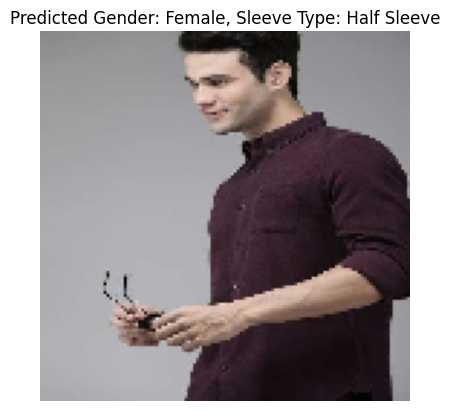

Image: /content/images/male/full_sleeve/02fd5910-6f17-4bda-ba8f-ddf698c5cac81676013985849THEBEARHOUSEMenPurpleSlimFitCasualShirt4.jpg
Predicted Gender: Female
Predicted Sleeve Type: Half Sleeve




In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(128, 128))  # Ensure the target size matches your model's input size
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array, image  # Return both the image array and PIL image

# Example image paths (update these paths with your new images)
new_image_paths = [
    '/content/images/female/full_sleeve/19ee012f-d1bc-4a95-a46d-bdbcb84b01e91691438760543HighStarWomenGreenClassicOpaqueCasualShirt1.jpg',
    '/content/images/male/full_sleeve/02fd5910-6f17-4bda-ba8f-ddf698c5cac81676013985849THEBEARHOUSEMenPurpleSlimFitCasualShirt4.jpg',
    # Add more paths as needed
]

# Function to make predictions on new images
def make_predictions(image_paths, gender_model, sleeve_model):
    for image_path in image_paths:
        image_array, image = load_and_preprocess_image(image_path)

        # Gender prediction
        gender_prediction = gender_model.predict(image_array)
        gender_class = np.argmax(gender_prediction, axis=1)[0]
        gender_label = 'Male' if gender_class == 0 else 'Female'

        # Sleeve type prediction
        sleeve_prediction = sleeve_model.predict(image_array)
        sleeve_class = np.argmax(sleeve_prediction, axis=1)[0]
        sleeve_label = 'Full Sleeve' if sleeve_class == 0 else 'Half Sleeve'

        # Display the image
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted Gender: {gender_label}, Sleeve Type: {sleeve_label}")
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted Gender: {gender_label}")
        print(f"Predicted Sleeve Type: {sleeve_label}")
        print("\n")

# Make predictions on the new images
make_predictions(new_image_paths, gender_model, sleeve_model)


#Project Title: Automated Fashion Product Classification using Web Scraping and Deep Learning
##Project Overview:
This project involves automating the classification of fashion products (shirts) based on their gender and sleeve type using web scraping and deep learning techniques. Here’s a breakdown of the project:

##Web Scraping with Selenium:

**Objective**: Gather data from Myntra's website on full-sleeve and half-sleeve shirts for both men and women.

**Tools Used**: Selenium for web automation, Pandas for data manipulation, and Requests for image downloading.

**Details**:

Selenium is used to navigate through each URL, extract product images, metadata (brand, name, price), and classify them by gender and sleeve type.

Images are downloaded and saved locally, and metadata is stored in a CSV (myntra_data.csv).

##Image Classification:

**Objective**: Develop two classification models using TensorFlow/Keras for gender and sleeve type.

**Models Used**: Convolutional Neural Networks (CNNs).

**Details**:

Images from the CSV are loaded, resized to 128x128 pixels, and preprocessed.

Two separate CNN models are created and trained:

1. Gender Classification: Determines whether the product is for males or females.

2. Sleeve Type Classification: Identifies whether the shirt is full-sleeve or half-sleeve.

Models are compiled with categorical cross-entropy loss and trained using a train-test split of the dataset.

##Prediction on New Images:

**Objective**: Predict the gender and sleeve type of new shirt images using trained models.

**Details:**

New image paths are provided for prediction.
Images are loaded, preprocessed, and fed into the trained models.

Predictions are made and displayed alongside the corresponding images.

##Code Explanation:

**Web Scraping:** Uses Selenium to automate browsing, extract product details, and download images. Metadata and image paths are saved into a CSV.

**Image Loading and Preprocessing**: Loads images from paths stored in the CSV, resizes them to fit the model input, and prepares them for training.

**Model Creation and Training**: Defines CNN architectures for gender and sleeve type classification. Trains each model separately using the preprocessed image data.

**Prediction Function**: Loads new images, preprocesses them, and uses trained models to predict their gender and sleeve type.

This project combines web scraping for data collection and deep learning for image classification, demonstrating an end-to-end pipeline for automated fashion product classification.
--------------





